In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import networkx.algorithms.community as nx_comm
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
connectome_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'

In [3]:
file = os.path.join(connectome_dir, 'traced-total-connections.csv')
full_adj = np.genfromtxt(file, delimiter=',')
full_adj.shape

(3413161, 3)

In [4]:
cell_ids_adj = np.unique(list(full_adj[:,0]) + list(full_adj[:,1]))[:-2] #-2 removes 2 nans

In [4]:
file = os.path.join(connectome_dir, '20220817_full_adj.npy')
adj = np.load(file)

In [5]:
adj_sym = (adj + adj.T)/2

In [7]:
adj_sym.shape

(21662, 21662)

In [6]:
import umap

In [25]:
n_neighbors = 10

t0 = time.time()
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0, n_components=2)
X = reducer.fit_transform(adj_sym)
print('Duration: {}'.format(time.time()-t0))

Duration: 150.7568235397339


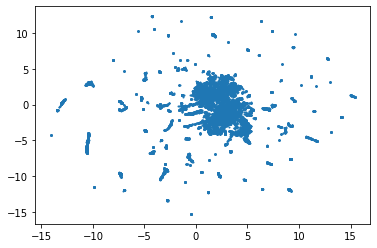

In [26]:
plt.scatter(X[:,0], X[:,1], s=1)

In [123]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=connectome_dir,
                                linkage='ward')
model = model.fit(adj_sym)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
8.809143781661987


In [ ]:
#at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i.

In [124]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [125]:
model.children_.shape

(21661, 2)

In [136]:
model.children_[-1]

array([43320, 43321])

In [126]:
model.labels_.shape

(21662,)

In [127]:
linkage_matrix.shape

(21661, 4)

In [134]:
linkage_matrix

array([[1.76300000e+04, 1.77060000e+04, 1.41421356e+00, 2.00000000e+00],
       [1.60620000e+04, 1.92060000e+04, 1.50000000e+00, 2.00000000e+00],
       [1.71560000e+04, 1.74760000e+04, 1.73205081e+00, 2.00000000e+00],
       ...,
       [1.88000000e+03, 2.13390000e+04, 4.53922163e+03, 2.00000000e+00],
       [4.33180000e+04, 4.33190000e+04, 5.50937190e+03, 2.16600000e+04],
       [4.33200000e+04, 4.33210000e+04, 5.87597671e+03, 2.16620000e+04]])

In [129]:
model.children_[100,:]

array([16439, 16447])

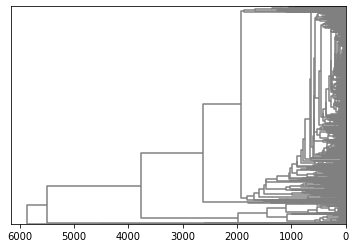

In [133]:
dend = dendrogram(linkage_matrix[:,:],
           truncate_mode=None,
           p=0,
           color_threshold=0,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

In [27]:
G = nx.from_numpy_array(adj_sym)

In [77]:
small_G = nx.from_numpy_array(adj_sym[:1000,:1000])

In [36]:
from community import community_louvain, partition_at_level

In [64]:
out = community_louvain.generate_dendrogram(G,resolution=50)

In [65]:
len(out[0])

21662

In [ ]:
#The first one will have node as key and first partitioning as value.
#The second one will have first partitioning as key, second partitioning as value. 

In [74]:
out[1]

{1028: 0,
 1200: 1,
 1246: 5,
 202: 3,
 647: 4,
 909: 5,
 611: 6,
 955: 7,
 26: 945,
 28: 804,
 1031: 86,
 20: 945,
 319: 12,
 27: 1014,
 29: 945,
 643: 15,
 1188: 16,
 523: 17,
 25: 18,
 115: 19,
 749: 127,
 397: 15,
 472: 22,
 992: 26,
 914: 24,
 436: 25,
 744: 26,
 594: 3,
 1130: 28,
 52: 29,
 830: 398,
 793: 31,
 1157: 32,
 790: 33,
 373: 34,
 1092: 35,
 1012: 317,
 393: 37,
 1224: 68,
 91: 39,
 351: 24,
 386: 41,
 988: 42,
 1162: 43,
 541: 44,
 739: 85,
 990: 46,
 1317: 47,
 377: 1055,
 134: 49,
 101: 86,
 675: 51,
 915: 52,
 104: 10,
 222: 74,
 1015: 55,
 260: 128,
 415: 59,
 162: 10,
 182: 59,
 1046: 60,
 1088: 127,
 210: 62,
 362: 63,
 3: 252,
 566: 65,
 242: 66,
 192: 44,
 741: 68,
 1176: 69,
 1271: 70,
 183: 71,
 354: 72,
 1269: 73,
 416: 74,
 1125: 75,
 950: 76,
 609: 77,
 646: 78,
 1322: 79,
 353: 34,
 305: 81,
 1158: 82,
 651: 83,
 1003: 84,
 822: 85,
 891: 86,
 388: 87,
 520: 432,
 359: 89,
 460: 7,
 336: 91,
 400: 92,
 392: 93,
 527: 35,
 564: 106,
 601: 96,
 398: 97,
 9

In [66]:
len(out)

2

In [87]:
temp = partition_at_level(dendrogram=out, level=0)
len(np.unique(list(temp.values())))

25

In [49]:
len(np.unique(list(temp.values())))

229

In [54]:
21000/230

91.30434782608695

In [144]:
out, dendro_history_first = generate_dendrogram(G)

In [156]:
dendro_history_first.shape

AttributeError: 'list' object has no attribute 'shape'

In [145]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/all_neuron_dice.npy'
all_neuron_dice = np.load(file)
all_neuron_dice.shape

(24691, 3)

(0, 100)

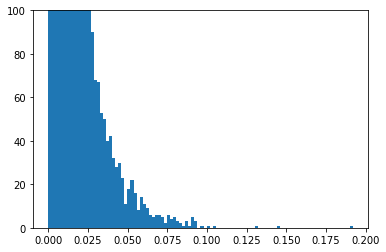

In [146]:
plt.hist(all_neuron_dice[:,1],bins=100);
plt.ylim(0,100)

In [147]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/hemibrain_all_neurons_synapses_polypre_centrifugal_synapses.pickle'
file = open(file, 'rb')
synapses = pickle.load(file)
cell_ids = np.unique(synapses['bodyid'])

In [152]:
cell_ids = np.unique(synapses['bodyid'])

In [160]:
dice_thresh = .055#.075
beh = 1
thresh_idx = np.searchsorted(np.sort(all_neuron_dice[:,beh]), dice_thresh)
top_indicies = np.argsort(all_neuron_dice[:,beh])[thresh_idx:]
top_cell_ids = cell_ids[top_indicies]
top_cell_ids = [int(i) for i in top_cell_ids]
print(len(top_cell_ids))

115


In [154]:
len(cell_ids), len(cell_ids_adj)

(24691, 21662)

In [159]:
test.shape

(39712, 21662)

In [199]:
len(np.unique(test[10000,:]))

12217

In [230]:
labels = test[i,:]
counts = []
for label in np.unique(labels):
    count = np.count_nonzero(labels == label)
    counts.append(count)

(0, 100)

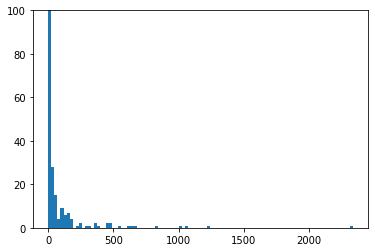

In [231]:
plt.hist(counts,bins=100);
plt.ylim(0,100)

In [254]:
np.sum(21127 == test[25731,:])

15

In [166]:
test[-1,:]

array([ 7930, 19305,  7023, ...,   392,   731, 17460])

In [ ]:
# basically we should give higher scores to larger communities that have a high % of their cells in the list
# or, the first point at which x% of identified cells belong to 1,2,3 etc communities

In [206]:
labels = []
for cell in top_cell_ids:
    idx = np.where(cell==cell_ids_adj)[0][0]
    labels.append(test[-1,:][idx])

In [224]:
indicies = []
for cell in top_cell_ids:
    indicies.append(np.where(cell==cell_ids_adj)[0][0])

for i in tqdm.tqdm(range(test.shape[0])):
    labels = []
    for idx in indicies:
        labels.append(test[i,:][idx])

    counts = []
    for label in np.unique(labels):
        count = np.count_nonzero(labels == label)
        counts.append(count)

    frac_in_top = np.sum(np.sort(counts)[::-1][:3])/len(top_cell_ids)
    if frac_in_top > .5:
        break

 65%|██████▍   | 25731/39712 [00:19<00:10, 1299.11it/s]


In [234]:
i = 25731
labels = []
for idx in indicies:
    labels.append(test[i,:][idx])

counts = []
for label in np.unique(labels):
    count = np.count_nonzero(labels == label)
    counts.append(count)

In [246]:
np.argsort(counts)[::-1]

array([16, 32, 17, 31,  0, 27,  2, 20, 12,  3, 24, 18, 14,  4,  5, 10,  7,
        1,  8,  9,  6, 30, 11, 13, 29, 19, 21, 22, 23, 25, 26, 28, 15])

In [252]:
labels[32]

21127

In [241]:
len(counts)

33

In [239]:
len(np.unique(labels))

33

In [225]:
i

25731

In [233]:
len(np.unique(labels))

1107

In [244]:
counts

[5,
 1,
 5,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 26,
 8,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 5,
 1,
 1,
 1,
 7,
 24]

In [228]:
len(np.unique(test[i,:]))

1107

In [211]:
np.sum([18,38,24])/115

0.6956521739130435

In [169]:
np.where(top_cell_ids[0]==cell_ids_adj)[0][0]

6188

In [ ]:
labels = 

In [108]:
out[0]

{0: 10,
 1: 3,
 2: 3,
 3: 3,
 4: 3,
 5: 3,
 6: 3,
 7: 3,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 12,
 15: 3,
 16: 12,
 17: 17,
 18: 15,
 19: 10,
 20: 17,
 21: 3,
 22: 3,
 23: 3,
 24: 3,
 25: 14,
 26: 17,
 27: 14,
 28: 15,
 29: 19,
 30: 7,
 31: 19,
 32: 5,
 33: 5,
 34: 10,
 35: 6,
 36: 3,
 37: 3,
 38: 3,
 39: 3,
 40: 3,
 41: 3,
 42: 3,
 43: 3,
 44: 3,
 45: 6,
 46: 3,
 47: 8,
 48: 7,
 49: 3,
 50: 12,
 51: 12,
 52: 12,
 53: 7,
 54: 3,
 55: 5,
 56: 13,
 57: 12,
 58: 3,
 59: 7,
 60: 7,
 61: 3,
 62: 3,
 63: 3,
 64: 3,
 65: 0,
 66: 3,
 67: 13,
 68: 13,
 69: 12,
 70: 5,
 71: 13,
 72: 5,
 73: 13,
 74: 12,
 75: 12,
 76: 13,
 77: 5,
 78: 13,
 79: 13,
 80: 9,
 81: 12,
 82: 13,
 83: 2,
 84: 5,
 85: 0,
 86: 10,
 87: 10,
 88: 10,
 89: 10,
 90: 10,
 91: 10,
 92: 10,
 93: 10,
 94: 10,
 95: 10,
 96: 10,
 97: 5,
 98: 10,
 99: 10,
 100: 10,
 101: 10,
 102: 10,
 103: 10,
 104: 10,
 105: 10,
 106: 10,
 107: 10,
 108: 10,
 109: 10,
 110: 10,
 111: 10,
 112: 10,
 113: 10,
 114: 3,
 115: 6,
 116: 6,

In [157]:
test = np.asarray(dendro_history_first)

In [158]:
test.shape

(39712, 21662)

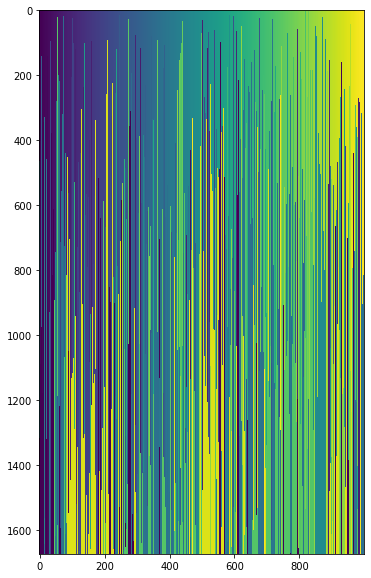

In [116]:
plt.figure(figsize=(10,10))
plt.imshow(test)

In [119]:
from scipy.cluster import hierarchy


In [120]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(ytdist, 'single')

In [122]:
Z.shape

(5, 4)

In [137]:
test.shape

(1674, 1000)

In [138]:
unis = []
for i in range(test.shape[0]):
    unis.append(len(np.unique(test[i,:])))

In [143]:
unis

[999,
 998,
 997,
 996,
 995,
 994,
 993,
 992,
 991,
 990,
 989,
 988,
 987,
 986,
 985,
 984,
 983,
 982,
 981,
 980,
 979,
 978,
 977,
 976,
 975,
 974,
 973,
 972,
 971,
 970,
 969,
 968,
 967,
 966,
 965,
 964,
 963,
 962,
 961,
 960,
 959,
 958,
 957,
 956,
 955,
 954,
 953,
 952,
 951,
 950,
 949,
 948,
 948,
 947,
 946,
 945,
 944,
 943,
 942,
 941,
 940,
 939,
 938,
 937,
 936,
 935,
 934,
 933,
 932,
 931,
 930,
 929,
 928,
 927,
 926,
 926,
 925,
 924,
 923,
 922,
 921,
 920,
 919,
 918,
 917,
 916,
 915,
 914,
 913,
 913,
 912,
 911,
 910,
 909,
 908,
 907,
 906,
 905,
 904,
 904,
 903,
 902,
 901,
 900,
 899,
 898,
 897,
 896,
 895,
 895,
 894,
 893,
 892,
 891,
 890,
 889,
 888,
 887,
 886,
 885,
 884,
 883,
 882,
 881,
 880,
 879,
 878,
 878,
 877,
 876,
 875,
 874,
 873,
 872,
 871,
 870,
 869,
 868,
 867,
 866,
 865,
 864,
 863,
 862,
 861,
 860,
 859,
 858,
 857,
 856,
 855,
 854,
 853,
 852,
 851,
 850,
 849,
 848,
 847,
 847,
 846,
 845,
 844,
 843,
 843,
 842,
 842

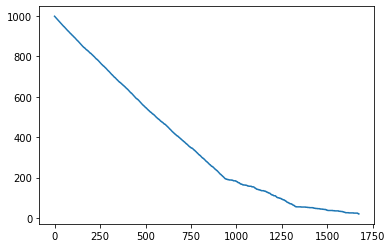

In [139]:
plt.plot(unis)

In [97]:
list(dendro_history_first[2].values())

[202,
 147,
 202,
 147,
 147,
 202,
 202,
 147,
 147,
 147,
 147,
 147,
 287,
 147,
 373,
 147,
 449,
 26,
 18,
 202,
 26,
 147,
 287,
 147,
 147,
 27,
 26,
 27,
 18,
 29,
 30,
 29,
 392,
 392,
 202,
 202,
 147,
 147,
 147,
 147,
 202,
 147,
 147,
 147,
 147,
 202,
 147,
 749,
 30,
 147,
 449,
 392,
 30,
 30,
 147,
 392,
 731,
 373,
 147,
 30,
 30,
 147,
 147,
 147,
 147,
 832,
 202,
 731,
 731,
 373,
 392,
 731,
 392,
 731,
 373,
 392,
 731,
 392,
 731,
 731,
 392,
 449,
 731,
 484,
 392,
 832,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 392,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 147,
 202,
 202,
 202,
 202,
 147,
 202,
 202,
 202,
 147,
 373,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 147,
 147,
 202,
 147,
 147,
 202,
 202,
 373,
 202,
 147,
 202,
 202,
 202,
 147,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 

In [98]:
def modularity(partition, graph, weight='weight'):
    """Compute the modularity of a partition of a graph
    Parameters
    ----------
    partition : dict
       the partition of the nodes, i.e a dictionary where keys are their nodes
       and values the communities
    graph : networkx.Graph
       the networkx graph which is decomposed
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    Returns
    -------
    modularity : float
       The modularity
    Raises
    ------
    KeyError
       If the partition is not a partition of all graph nodes
    ValueError
        If the graph has no link
    TypeError
        If graph is not a networkx.Graph
    References
    ----------
    .. 1. Newman, M.E.J. & Girvan, M. Finding and evaluating community
    structure in networks. Physical Review E 69, 26113(2004).
    Examples
    --------
    >>> import community as community_louvain
    >>> import networkx as nx
    >>> G = nx.erdos_renyi_graph(100, 0.01)
    >>> partition = community_louvain.best_partition(G)
    >>> modularity(partition, G)
    """
    if graph.is_directed():
        raise TypeError("Bad graph type, use only non directed graph")

    inc = dict([])
    deg = dict([])
    links = graph.size(weight=weight)
    if links == 0:
        raise ValueError("A graph without link has an undefined modularity")

    for node in graph:
        com = partition[node]
        deg[com] = deg.get(com, 0.) + graph.degree(node, weight=weight)
        for neighbor, datas in graph[node].items():
            edge_weight = datas.get(weight, 1)
            if partition[neighbor] == com:
                if neighbor == node:
                    inc[com] = inc.get(com, 0.) + float(edge_weight)
                else:
                    inc[com] = inc.get(com, 0.) + float(edge_weight) / 2.

    res = 0.
    for com in set(partition.values()):
        res += (inc.get(com, 0.) / links) - \
               (deg.get(com, 0.) / (2. * links)) ** 2
    return res

def generate_dendrogram(graph,
                        part_init=None,
                        weight='weight',
                        resolution=1.,
                        randomize=None,
                        random_state=None):
    """Find communities in the graph and return the associated dendrogram
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1. The higher the level is, the bigger
    are the communities
    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    part_init : dict, optional
        the algorithm will start using this partition of the nodes. It's a
        dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the
        values of the i. and where keys of the first are the nodes of graph
    Raises
    ------
    TypeError
        If the graph is not a networkx.Graph
    See Also
    --------
    best_partition
    Notes
    -----
    Uses Louvain algorithm
    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large
    networks. J. Stat. Mech 10008, 1-12(2008).
    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print("partition at level", level,
    >>>           "is", partition_at_level(dendo, level))
    :param weight:
    :type weight:
    """
    if graph.is_directed():
        raise TypeError("Bad graph type, use only non directed graph")

    # Properly handle random state, eventually remove old `randomize` parameter
    # NOTE: when `randomize` is removed, delete code up to random_state = ...
    if randomize is not None:
        warnings.warn("The `randomize` parameter will be deprecated in future "
                      "versions. Use `random_state` instead.", DeprecationWarning)
        # If shouldn't randomize, we set a fixed seed to get determinisitc results
        if randomize is False:
            random_state = 0

    # We don't know what to do if both `randomize` and `random_state` are defined
    if randomize and random_state is not None:
        raise ValueError("`randomize` and `random_state` cannot be used at the "
                         "same time")

    random_state = check_random_state(random_state)

    # special case, when there is no link
    # the best partition is everyone in its community
    if graph.number_of_edges() == 0:
        part = dict([])
        for i, node in enumerate(graph.nodes()):
            part[node] = i
        return [part]

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, weight, part_init)
    status_list = list()
    dendro_history_first = __one_level(current_graph, status, weight, resolution, random_state)
    new_mod = __modularity(status, resolution)
    partition = __renumber(status.node2com)
    status_list.append(partition)
    mod = new_mod
    current_graph = induced_graph(partition, current_graph, weight)
    status.init(current_graph, weight)

    while True:
        dendro_history = __one_level(current_graph, status, weight, resolution, random_state)
        new_mod = __modularity(status, resolution)
        if new_mod - mod < __MIN:
            break
        partition = __renumber(status.node2com)
        status_list.append(partition)
        mod = new_mod
        current_graph = induced_graph(partition, current_graph, weight)
        status.init(current_graph, weight)
    return status_list[:], dendro_history_first


def induced_graph(partition, graph, weight="weight"):
    """Produce the graph where nodes are the communities
    there is a link of weight w between communities if the sum of the weights
    of the links between their elements is w
    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node
       belongs to
    graph : networkx.Graph
        the initial graph
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts
    Examples
    --------
    >>> n = 5
    >>> g = nx.complete_graph(2*n)
    >>> part = dict([])
    >>> for node in g.nodes() :
    >>>     part[node] = node % 2
    >>> ind = induced_graph(part, g)
    >>> goal = nx.Graph()
    >>> goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])  # NOQA
    >>> nx.is_isomorphic(ind, goal)
    True
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas.get(weight, 1)
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight: 0}).get(weight, 1)
        ret.add_edge(com1, com2, **{weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = set(dictionary.values())
    target = set(range(len(values)))

    if values == target:
        # no renumbering necessary
        ret = dictionary.copy()
    else:
        # add the values that won't be renumbered
        renumbering = dict(zip(target.intersection(values),
                               target.intersection(values)))
        # add the values that will be renumbered
        renumbering.update(dict(zip(values.difference(target),
                                    target.difference(values))))
        ret = {k: renumbering[v] for k, v in dictionary.items()}

    return ret

def __one_level(graph, status, weight_key, resolution, random_state):
    """Compute one level of communities
    """
    modified = True
    nb_pass_done = 0
    cur_mod = __modularity(status, resolution)
    new_mod = cur_mod
    dendro_history = []

    while modified and nb_pass_done != __PASS_MAX:
        cur_mod = new_mod
        modified = False
        nb_pass_done += 1

        for node in __randomize(graph.nodes(), random_state):
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.)  # NOQA
            neigh_communities = __neighcom(node, graph, status, weight_key)
            remove_cost = - neigh_communities.get(com_node,0) + \
                resolution * (status.degrees.get(com_node, 0.) - status.gdegrees.get(node, 0.)) * degc_totw
            __remove(node, com_node,
                     neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = 0
            for com, dnc in __randomize(neigh_communities.items(), random_state):
                incr = remove_cost + dnc - \
                       resolution * status.degrees.get(com, 0.) * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_com = com
            __insert(node, best_com,
                     neigh_communities.get(best_com, 0.), status)
            if best_com != com_node:
                modified = True
                dendro_history.append(list(status.node2com.values())) ### LUKE
        new_mod = __modularity(status, resolution)
        if new_mod - cur_mod < __MIN:
            #break
            return dendro_history


def __neighcom(node, graph, status, weight_key):
    """
    Compute the communities in the neighborhood of node in the graph given
    with the decomposition node2com
    """
    weights = {}
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            edge_weight = datas.get(weight_key, 1)
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] = weights.get(neighborcom, 0) + edge_weight

    return weights


def __remove(node, com, weight, status):
    """ Remove node from community com and modify status"""
    status.degrees[com] = (status.degrees.get(com, 0.)
                           - status.gdegrees.get(node, 0.))
    status.internals[com] = float(status.internals.get(com, 0.) -
                                  weight - status.loops.get(node, 0.))
    status.node2com[node] = -1


def __insert(node, com, weight, status):
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] = (status.degrees.get(com, 0.) +
                           status.gdegrees.get(node, 0.))
    status.internals[com] = float(status.internals.get(com, 0.) +
                                  weight + status.loops.get(node, 0.))


def __modularity(status, resolution):
    """
    Fast compute the modularity of the partition of the graph using
    status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()):
        in_degree = status.internals.get(community, 0.)
        degree = status.degrees.get(community, 0.)
        if links > 0:
            result += in_degree * resolution / links -  ((degree / (2. * links)) ** 2)
    return result


def __randomize(items, random_state):
    """Returns a List containing a random permutation of items"""
    randomized_items = list(items)
    random_state.shuffle(randomized_items)
    return randomized_items

class Status(object):
    """
    To handle several data in one struct.
    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.loops = dict([])

    def __str__(self):
        return ("node2com : " + str(self.node2com) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, weight, part=None):
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node2com[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad node degree ({})".format(deg)
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, default={weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] = self.degrees.get(com, 0) + deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas.get(weight, 1)
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            inc += float(edge_weight)
                        else:
                            inc += float(edge_weight) / 2.
                self.internals[com] = self.internals.get(com, 0) + inc
                
__PASS_MAX = -1
__MIN = 0.0000001


def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.
    Parameters
    ----------
    seed : None | int | instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError("%r cannot be used to seed a numpy.random.RandomState"
                     " instance" % seed)